# Create ML Model

## Entrada

Arquivo com todas as label preenchdidas eplas etapas anteriores

## Quando se faz Hyper-turning

É somente depois de tentar várias possibildiades com os mdelos. O hyper-turning nâo faz milagre, entao só deixa pro final.

## Descriçâo das aulas

31 - Inicio do Notebook e testando hyer-turning no RandomForest

32 - LightGBM e Sua hyperturning
+ As formas de fazer hipertuning são:
   - GridSearhc: ALém de demorada nâo tem bons resultados pois é manual e nao sabemos até que potnao estamos atingindo um bom valor o hiper-parametro que causae uma mudança positiva
   - RandomSearch: Tende a ser melhor que GridSearch
   - Baysean Optimization (AutoML): Uma nova abordagem que vamos usar nesse notebook.
     * É uma busca alertória mas guiada de forma inteligente
     
33 - Logistic Regression
+ Vamos aprender como analisar as nossa features para a regresão logistica
  - Aprensetou bons resultados
  
### Tabela de Score
````
RandomForest
 avg_precision :: 0.3876787322730141 ; roc_auc :: 0.6775564963329557
LightGBM - No Hyper-Tuning
 avg_precision :: 0.358824358569258  ; roc_auc :: 0.644678313755888
LightBGM com Baysian Optimizer
'avg_precision': 0.40242103560963294 ; 'roc': 0.6723749329199212, 
Logistic REgression = C=0.5 StandardScaler
(0.41578009994342235, 0.6897143879315486) -  
````

In [83]:
import pandas as pd
import numpy as np
import tqdm
import datetime
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy import sparse

pd.set_option("max.columns", None)

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Importar e analisar DataSet

In [10]:
df = pd.read_csv("dataset.csv", sep=";").dropna(subset=['interesting'])
# df = pd.read_csv("raw_videos_dataset_manual_labeled_tabulation.tsv", index_col=0, sep="\t").dropna(subset=['interesting'])
df.shape

(1645, 14)

In [11]:
df.head(1)

,uploader,title,interesting,upload_date,user,view_count,like_count,thumbnail,width,height,categories,tags,channel_url,description
0,AltexSoft,How Data Engineering Works,1.0,2021-03-17,AltexSoftChannel,70764,4014,https://i.ytimg.com/vi/qWru-b6m030/maxresdefau...,1920,1080,Science & Technology,data engineering|data science|data infrastruct...,https://www.youtube.com/channel/UCEKI_F16hUtBH...,"So, the sole purpose of data engineering is to..."


In [12]:
df['interesting'].value_counts()

0.0    1351
1.0     294
Name: interesting, dtype: int64

In [13]:
# isnull()
df['interesting'].value_counts().isnull().sum()

0

In [14]:
# Sem duplicata
df.duplicated().sum()

0

In [15]:
# Sem duplicata nos titulos
df.duplicated(['title']).sum()

0

In [16]:
df = df.drop_duplicates(['title'])
df.shape

(1645, 14)

In [18]:
df['interesting'] = df['interesting'].astype(float)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1645 entries, 0 to 1644
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uploader     1645 non-null   object 
 1   title        1645 non-null   object 
 2   interesting  1645 non-null   float64
 3   upload_date  1645 non-null   object 
 4   user         1645 non-null   object 
 5   view_count   1645 non-null   int64  
 6   like_count   1645 non-null   int64  
 7   thumbnail    1645 non-null   object 
 8   width        1645 non-null   int64  
 9   height       1645 non-null   int64  
 10  categories   1645 non-null   object 
 11  tags         1207 non-null   object 
 12  channel_url  1645 non-null   object 
 13  description  1558 non-null   object 
dtypes: float64(1), int64(4), object(9)
memory usage: 192.8+ KB


In [20]:
df.head()

,uploader,title,interesting,upload_date,user,view_count,like_count,thumbnail,width,height,categories,tags,channel_url,description
0,AltexSoft,How Data Engineering Works,1.0,2021-03-17,AltexSoftChannel,70764,4014,https://i.ytimg.com/vi/qWru-b6m030/maxresdefau...,1920,1080,Science & Technology,data engineering|data science|data infrastruct...,https://www.youtube.com/channel/UCEKI_F16hUtBH...,"So, the sole purpose of data engineering is to..."
1,Seja Um Data Scientist,[Parte 01] Como é o Trabalho de um Data Engine...,0.0,2020-05-25,UCar5Cr-pVz08GY_6I3RX9bA,11125,814,https://i.ytimg.com/vi_webp/nQu6s8FPhfA/maxres...,1920,1080,Science & Technology,data engineer|engenheiro de dados o que faz|fo...,https://www.youtube.com/channel/UCar5Cr-pVz08G...,"Nesse vídeo, eu vou mostrar qual o papel de um..."
2,Seattle Data Guy,Data Engineering Road Map - How To Learn Data ...,1.0,2021-07-06,UCmLGJ3VYBcfRaWbP6JLJcpA,48598,2561,https://i.ytimg.com/vi_webp/SpaFPPByOhM/maxres...,1920,1080,Education,big data|data analytics|tableau|sql|big query|...,https://www.youtube.com/channel/UCmLGJ3VYBcfRa...,How do you go from 0 to data engineer? What i...
3,Joma Tech,Data Scientists vs Data Engineers: Which one i...,1.0,2019-12-19,UCV0qA-eDDICsRR9rPcnG7tw,246236,6683,https://i.ytimg.com/vi/vmYaAzbv9xk/maxresdefau...,1920,1080,Education,joma|vlog|data scientist|data science|data eng...,https://www.youtube.com/channel/UCV0qA-eDDICsR...,📚 Video courses from JomaClass: 🎓 New to progr...
4,Seattle Data Guy,What Skills Do Data Engineers Need To Know,1.0,2021-04-08,UCmLGJ3VYBcfRaWbP6JLJcpA,33370,1870,https://i.ytimg.com/vi/LgSHaOvNodA/maxresdefau...,1920,1080,Education,big data|data analytics|tableau|sql|big query|...,https://www.youtube.com/channel/UCmLGJ3VYBcfRa...,Learn More about data engineering Googles DE c...


## Data Cleaning

### 1. Limpeza das datas

In [21]:
df_limpo = pd.DataFrame(index=df.index)
df_limpo['title'] = df['title']
df_limpo['date'] = pd.to_datetime(df['upload_date'])

### 2. Limpeza de views

In [22]:
views = df['view_count'].fillna(0)
df_limpo['views'] = views

## Feature Engineering

In [23]:
# As features vao ficar num dataset separado
features = pd.DataFrame(index=df_limpo.index)

# Y (target) tambem fica separado
y = df['interesting'].copy()

# Feature Enginneering
today = datetime.datetime.today().strftime("%Y-%m-%d")
features['tempo_desde_pub'] = (pd.to_datetime(today) -  df_limpo['date']) / np.timedelta64(1, 'D')
features['views'] = df_limpo['views']
features['views_por_dia'] = (features['views'] / features['tempo_desde_pub']).round(3)
features.drop(['tempo_desde_pub'], axis=1, inplace=True)

## Split Train and Test

Vamos dividir pela data, de forma que divida ao meioa s duas quantidade de dados.

Vamos dividir por tempo, pegar os menos de 2020/10/03 para treinar e o restante para validar.

Perceba que teve poucos casos, podemos mudar isso para por mais dados para treinar

In [103]:
def eda_categ_feat_desc_plot(series_categorical, title = ""):
    """Generate 2 plots: barplot with quantity and pieplot with percentage. 
       @series_categorical: categorical series
       @title: optional
    """
    series_name = series_categorical.name
    val_counts = series_categorical.value_counts()
    val_counts.name = 'quantity'
    val_percentage = series_categorical.value_counts(normalize=True)
    val_percentage.name = "percentage"
    val_concat = pd.concat([val_counts, val_percentage], axis = 1)
    val_concat.reset_index(level=0, inplace=True)
    val_concat = val_concat.rename( columns = {'index': series_name} )
    
    fig, ax = plt.subplots(figsize = (12,4), ncols=2, nrows=1) # figsize = (width, height)
    if(title != ""):
        fig.suptitle(title, fontsize=18)
        fig.subplots_adjust(top=0.8)

    s = sns.barplot(x=series_name, y='quantity', data=val_concat, ax=ax[0])
    for index, row in val_concat.iterrows():
        s.text(row.name, row['quantity'], row['quantity'], color='black', ha="center")

    s2 = val_concat.plot.pie(y='percentage', autopct=lambda value: '{:.2f}%'.format(value),
                             labels=val_concat[series_name].tolist(), legend=None, ax=ax[1],
                             title="Percentage Plot")

    ax[1].set_ylabel('')
    ax[0].set_title('Quantity Plot')

    plt.show()

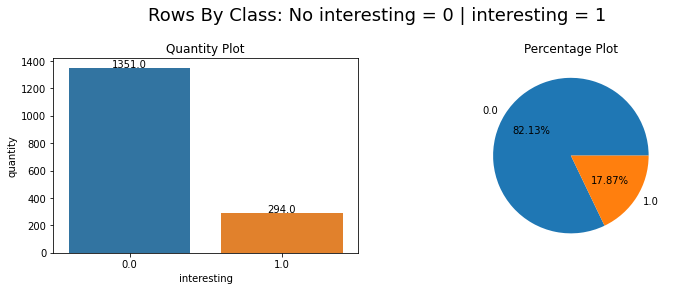

In [104]:
eda_categ_feat_desc_plot(df['interesting'], 'Rows By Class: No interesting = 0 | interesting = 1')

In [109]:
mask_train = df_limpo['date'] < '2021-03-10'
mask_val = df_limpo['date'] >= '2021-03-10'

Xtrain, Xval = features[mask_train], features[mask_val]
ytrain, yval = y[mask_train], y[mask_val]
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

# data         => train   , test
# '2020-03-10' => (546, 2), (1099, 2)
# '2021-03-10' => (991, 2), (654 , 2)

((991, 2), (654, 2), (991,), (654,))

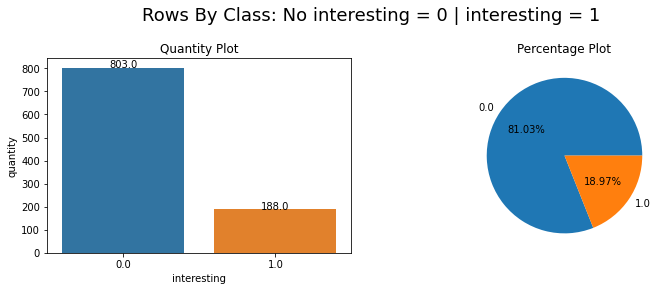

In [110]:
eda_categ_feat_desc_plot(ytrain, 'Rows By Class: No interesting = 0 | interesting = 1')

In [111]:
ytrain.head(1)

1    0.0
Name: interesting, dtype: float64

In [112]:
Xtrain.head(1)

,views,views_por_dia
1,11125,19.281


In [113]:
ytrain.head(1)

1    0.0
Name: interesting, dtype: float64

## Testando com apenas uma feature (NLTK)

Vamos usar um Vecotorizer para tokenizar os títulos e assim tentarmos fazer o treinamento só com palavras

In [114]:
# Buscando somente o 'title' para fazer a tokenização
title_train = df_limpo[mask_train]['title']
title_val = df_limpo[mask_val]['title']

# Min df - minimo de vezes que palavra tem que aparecer pra virar coluna
#        => min_df=2 quer dizer enta que a palavra tem que aparecer 2 vezes
#           no minimo para ela representar uma nova coluna
## ngram_range = vai fazer colunas para tanto 1 word "machine" quanto 2 juntas "machine learning"

title_vec = TfidfVectorizer(min_df=2, ngram_range=(1,2))

## Aplicando tokenizador
title_bow_train = title_vec.fit_transform(title_train)
title_bow_val = title_vec.transform(title_val)

**Convertemos o nosso titulo para um vetor de tamanho 1134, sendo esas a quantidade de palavras distintas**

Como é um array esparso (ou seja, esta preenhcido de muito zero) é difícil por isso na tela

In [115]:
title_bow_train.shape

(991, 1459)

In [116]:
title_bow_train[0][0]

<1x1459 sparse matrix of type '<class 'numpy.float64'>'
	with 18 stored elements in Compressed Sparse Row format>

## Concatenando as variávels numéricas com as geradas pelo TfidfVectorizer

In [117]:
Xtrain_wtitle = sparse.hstack([Xtrain, title_bow_train])
Xval_wtitle = sparse.hstack([Xval, title_bow_val])
Xtrain_wtitle.shape, Xval_wtitle.shape

((991, 1461), (654, 1461))

## Modelo RandomForest

In [118]:
mdl_rf = RandomForestClassifier(n_estimators=1000,
                             min_samples_leaf=1, 
                             random_state=0, 
                             class_weight='balanced', 
                             n_jobs=4)
mdl_rf.fit(Xtrain_wtitle, ytrain)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=4,
                       random_state=0)

In [119]:
p_rf = mdl_rf.predict_proba(Xval_wtitle)[: ,1]

In [121]:
print('RandomForest')
print( " avg_precision :: " + str(metrics.average_precision_score(yval, p_rf)), '\n' ,
      "roc_auc :: " + str(metrics.roc_auc_score(yval, p_rf)) )
# RandomForest (2020-data)
#  avg_precision :: 0.32132819344300667 
#  roc_auc :: 0.6904048017867113
# RandomForest 2021-data
#  avg_precision :: 0.3695448177133478 
#  roc_auc :: 0.7520141853739153

RandomForest
 avg_precision :: 0.3695448177133478 
 roc_auc :: 0.7520141853739153


O melhor resultado que Mario encontrou para oe xemplo dele
min_df=2 ngram_range=(1,3)

## LightGBM

In [122]:
from lightgbm import LGBMClassifier

In [123]:
mdl_lgbm = LGBMClassifier(random_state=0, class_weight='balanced', n_jobs=4)
mdl_lgbm.fit(Xtrain_wtitle, ytrain)

LGBMClassifier(class_weight='balanced', n_jobs=4, random_state=0)

In [124]:
p_lgbm = mdl_lgbm.predict_proba(Xval_wtitle)[:, 1]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [126]:
# metrics.average_precision_score(yval, p), metrics.roc_auc_score(yval, p)
print('LightGBM - No Hyper-turning')
print( " avg_precision :: " + str(metrics.average_precision_score(yval, p_lgbm)), '\n' ,
      "roc_auc :: " + str(metrics.roc_auc_score(yval, p_lgbm)) )
# LightGBM - No Hyper-turning (2021 date)
#  avg_precision :: 0.2795196325547043 
#  roc_auc :: 0.6299493871367581

LightGBM - No Hyper-turning
 avg_precision :: 0.2795196325547043 
 roc_auc :: 0.6299493871367581


##  Bayesian Optimization

É uma opçâo avançada ao fazer GridSearch que é demorado) e RandomSearch (é melhor que o grid mas nâo tanto quanto Baysian).

**Bayesian Optimization É UM RANDOM-SEARCH OTIMIZADO**

In [70]:
!pip install scikit-optimize

In [71]:
# lib: scikit optimizer
from skopt import forest_minimize

In [127]:
results = []

def tune_lgbm(params):
    # Set Hyper-params
    tunning = {}
    print()
    print(params)
    lr = params[0]
    max_depth = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    min_df = params[6]
    ngram_range = (1, params[7])
    # Sety TDF-Vec hyper-params, generate vocabulary and apply over data
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    title_bow_train = title_vec.fit_transform(title_train)
    title_bow_val = title_vec.transform(title_val)
    # Join Numeric Features with TDF-Vec
    Xtrain_wtitle = sparse.hstack([Xtrain, title_bow_train])
    Xval_wtitle = sparse.hstack([Xval, title_bow_val])
    # Create Model with hyper-params
    mdl_lgbm = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                         min_child_samples=min_child_samples, subsample=subsample,
                         colsample_bytree=colsample_bytree, bagging_freq=1, n_estimators=n_estimators,
                        random_state=0, class_weight='balanced', n_jobs=4)
    # Fit Model
    mdl_lgbm.fit(Xtrain_wtitle, ytrain)
    # Predict
    pred = mdl_lgbm.predict_proba(Xval_wtitle)[:, 1]
    print(metrics.roc_auc_score(yval, pred))
    # Save Results
    tunning['params'] = params
    tunning['roc'] = metrics.roc_auc_score(yval, pred)
    tunning['avg_prec'] = metrics.average_precision_score(yval, pred)
    results.append(tunning)
    
    # Esta negativa pois eu quero maximizar a average-precision
    # como nao tem um 'skopt.forest_maximze' entao eu inverto a avg_precision para ter esse efeito de maximizar
    return -metrics.average_precision_score(yval, pred)


In [128]:
# INTERVALOS DOS HYPER-PARAMETROS  DO LIGHT-GBM E TDF-VEC
space = [(1e-3, 1e-1, 'log-uniform'), # learning-rate : usamos log-unifrom para ter mais chance de pegar valores pequenos
         (1,10), # max_depth
         (1,20), # min_child_samples
         (0.05, 1.), # subsample
         (0.05, 1.), # colsample_bytree
         (100, 1000), # n_estimators
         (1,5), # TDF-Vectorizer: min_df
         (1,5)] # TDF-Vectorizer: ngram_range

In [129]:
# EXEC skopt.forest_minimize (Baysian Optimization)
res = forest_minimize(tune_lgbm, # funçâo apra testar score que voce quer MINIMIZAR
                      space,  # hyper-paremtros e seu range
                      random_state=160745,
                      n_random_starts=20, # testar 20 vezes
                      n_calls=50, 
                      verbose=1)

Iteration No: 1 started. Evaluating function at random point.

[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 3, 1]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7059805811871643
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.9392
Function value obtained: -0.3588
Current minimum: -0.3588
Iteration No: 2 started. Evaluating function at random point.

[0.053887464791860025, 1, 15, 0.7437489153990157, 0.8675167974293533, 549, 3, 4]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6745369095165956
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3790
Function value obtained: -0.3453
Current minimum: -0.3588
Iteration No: 3 started. Evaluating function at random point.

[0.004151454520895999, 6, 20, 0.8682075103820793, 0.9491436163200662, 411, 4, 3]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6311114171601708
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.8857
Function value obtained: -0.2758
Current minimum: -0.3588
Iteration No: 4 started. Evaluating function at random point.

[0.0014099928811969545, 9, 9, 0.6502182010234373, 0.6866210554187129, 828, 5, 2]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6697510673460956
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.4533
Function value obtained: -0.2904
Current minimum: -0.3588
Iteration No: 5 started. Evaluating function at random point.

[0.08530558241838007, 8, 19, 0.2137736299768322, 0.1313765544201984, 961, 4, 1]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.627246591378598
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.8952
Function value obtained: -0.2690
Current minimum: -0.3588
Iteration No: 6 started. Evaluating function at random point.

[0.003567949451535685, 10, 19, 0.7232951768944309, 0.7298538828427115, 939, 4, 3]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6159533810769867
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 3.2944
Function value obtained: -0.2852
Current minimum: -0.3588
Iteration No: 7 started. Evaluating function at random point.

[0.014828577273549474, 7, 1, 0.18428087097824575, 0.3261556557915816, 274, 1, 2]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7165679658449249
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 2.3174
Function value obtained: -0.3554
Current minimum: -0.3588
Iteration No: 8 started. Evaluating function at random point.

[0.0015212976972079912, 3, 12, 0.44234694306528044, 0.399351303640462, 272, 3, 5]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6477069274204655
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.4201
Function value obtained: -0.2771
Current minimum: -0.3588
Iteration No: 9 started. Evaluating function at random point.

[0.01946212855369041, 9, 18, 0.5235636153223084, 0.6728679300083596, 747, 4, 5]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.5824524858834872
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 2.1025
Function value obtained: -0.2756
Current minimum: -0.3588
Iteration No: 10 started. Evaluating function at random point.

[0.0012116790683302117, 3, 2, 0.06616307483844217, 0.23025600705315752, 677, 2, 5]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.662477620162512
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.9970
Function value obtained: -0.2961
Current minimum: -0.3588
Iteration No: 11 started. Evaluating function at random point.

[0.0053139776214487944, 6, 9, 0.14251441334450304, 0.8175761405215897, 297, 1, 5]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6311974934582014
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.7220
Function value obtained: -0.2597
Current minimum: -0.3588
Iteration No: 12 started. Evaluating function at random point.

[0.0068572961982704935, 10, 5, 0.2390386584472456, 0.49053406102209746, 176, 2, 4]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6431018454758297
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.8817
Function value obtained: -0.2924
Current minimum: -0.3588
Iteration No: 13 started. Evaluating function at random point.

[0.00781968225875022, 3, 4, 0.7078936710077383, 0.31818755505678337, 275, 4, 4]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7135208648946427
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.4251
Function value obtained: -0.3453
Current minimum: -0.3588
Iteration No: 14 started. Evaluating function at random point.

[0.017293945600511968, 2, 15, 0.9007557574888567, 0.41026441194439994, 316, 5, 1]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7116099710783639
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 0.2517
Function value obtained: -0.3359
Current minimum: -0.3588
Iteration No: 15 started. Evaluating function at random point.

[0.012250750764764855, 8, 6, 0.5976582413192033, 0.2474882432951916, 516, 4, 4]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7045861451590691
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 1.5779
Function value obtained: -0.3464
Current minimum: -0.3588
Iteration No: 16 started. Evaluating function at random point.

[0.018353598126553926, 4, 3, 0.47305622526323254, 0.1404164811277527, 133, 4, 1]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7239877427351605
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 0.2510
Function value obtained: -0.3677
Current minimum: -0.3677
Iteration No: 17 started. Evaluating function at random point.

[0.0010383234748454694, 9, 19, 0.9256771571832196, 0.9321438677645206, 312, 4, 3]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.5723299132350916
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 1.3729
Function value obtained: -0.2290
Current minimum: -0.3677
Iteration No: 18 started. Evaluating function at random point.

[0.004955229758078229, 5, 5, 0.06939551310802591, 0.4193273080472823, 725, 4, 1]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6130267869439472
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.9833
Function value obtained: -0.2441
Current minimum: -0.3677
Iteration No: 19 started. Evaluating function at random point.

[0.0699516121742407, 9, 10, 0.6477856515609233, 0.8594430701440198, 616, 1, 1]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6091017077537528
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 2.1616
Function value obtained: -0.2685
Current minimum: -0.3677
Iteration No: 20 started. Evaluating function at random point.

[0.0014752743467850462, 5, 4, 0.9747950537021096, 0.982207187458162, 909, 2, 4]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6908827985126015
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 3.2137
Function value obtained: -0.3196
Current minimum: -0.3677
Iteration No: 21 started. Searching for the next optimal point.

[0.03152013830463717, 6, 1, 0.4221972258604987, 0.7793028917043491, 261, 4, 1]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6547823991185787
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.6046
Function value obtained: -0.3241
Current minimum: -0.3677
Iteration No: 22 started. Searching for the next optimal point.

[0.047119432178093244, 4, 2, 0.06674456023919131, 0.20189457238965225, 285, 1, 1]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6613758435477207
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.8531
Function value obtained: -0.3313
Current minimum: -0.3677
Iteration No: 23 started. Searching for the next optimal point.

[0.004214110497482603, 3, 2, 0.7411545546413325, 0.10558371474852957, 237, 5, 1]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7316141027406693
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.6220
Function value obtained: -0.3582
Current minimum: -0.3677
Iteration No: 24 started. Searching for the next optimal point.

[0.0010802599797676807, 4, 1, 0.47429140454497676, 0.18376555914466497, 543, 4, 1]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7153112518936786
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 1.3787
Function value obtained: -0.3556
Current minimum: -0.3677
Iteration No: 25 started. Searching for the next optimal point.

[0.007377295047756928, 3, 1, 0.49169769784563405, 0.05486864729034782, 695, 4, 2]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.75509571684341
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 1.1867
Function value obtained: -0.3954
Current minimum: -0.3954
Iteration No: 26 started. Searching for the next optimal point.

[0.07020599776190001, 2, 6, 0.4673415880886938, 0.06139259432599684, 962, 5, 2]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7237209062112658
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.1131
Function value obtained: -0.3406
Current minimum: -0.3954
Iteration No: 27 started. Searching for the next optimal point.

[0.003664747337610642, 3, 2, 0.2524791341639531, 0.05288605602607631, 705, 3, 2]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7110246522517559
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.1095
Function value obtained: -0.3842
Current minimum: -0.3954
Iteration No: 28 started. Searching for the next optimal point.

[0.001701571642852573, 4, 4, 0.15203995448330185, 0.06633424603398541, 130, 3, 2]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6174683239223246
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5328
Function value obtained: -0.3104
Current minimum: -0.3954
Iteration No: 29 started. Searching for the next optimal point.

[0.006732012793982591, 3, 2, 0.9302027182012595, 0.11446482212394127, 842, 5, 5]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7489412615342239
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.3674
Function value obtained: -0.3891
Current minimum: -0.3954
Iteration No: 30 started. Searching for the next optimal point.

[0.0030548796010550685, 1, 2, 0.16444901604635442, 0.1394460547588698, 973, 5, 2]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6558067070651425
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.9990
Function value obtained: -0.3325
Current minimum: -0.3954
Iteration No: 31 started. Searching for the next optimal point.

[0.08449615639626112, 7, 2, 0.9978085862739342, 0.12528411834292968, 818, 3, 4]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7151390992976173
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 3.0735
Function value obtained: -0.3886
Current minimum: -0.3954
Iteration No: 32 started. Searching for the next optimal point.

[0.0047914253948709495, 9, 2, 0.5727127578461335, 0.07696303711083324, 871, 4, 3]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7364171601707754
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 4.4158
Function value obtained: -0.3643
Current minimum: -0.3954
Iteration No: 33 started. Searching for the next optimal point.

[0.05045523013775797, 5, 2, 0.21569506404018318, 0.05860144764773518, 905, 5, 4]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6360521966671258
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.9087
Function value obtained: -0.2580
Current minimum: -0.3954
Iteration No: 34 started. Searching for the next optimal point.

[0.05328144863481819, 5, 2, 0.5430817944183729, 0.13394616511822904, 727, 5, 5]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6982164991048064
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.9202
Function value obtained: -0.3282
Current minimum: -0.3954
Iteration No: 35 started. Searching for the next optimal point.

[0.005177047192178273, 7, 3, 0.8676245652823552, 0.06541064645088063, 686, 4, 3]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7557498967084424
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 2.4953
Function value obtained: -0.3824
Current minimum: -0.3954
Iteration No: 36 started. Searching for the next optimal point.

[0.04674909666222952, 6, 2, 0.9840854048613735, 0.06454340695948732, 886, 1, 4]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7463159344442915
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 3.1348
Function value obtained: -0.3740
Current minimum: -0.3954
Iteration No: 37 started. Searching for the next optimal point.

[0.004704522818621336, 6, 5, 0.9623638710458965, 0.0512745318716151, 507, 2, 2]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7025891750447597
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 1.3360
Function value obtained: -0.3377
Current minimum: -0.3954
Iteration No: 38 started. Searching for the next optimal point.

[0.005249549776374319, 4, 1, 0.9317030641833104, 0.29361684326916104, 793, 3, 5]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7268196529403664
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 2.1760
Function value obtained: -0.3871
Current minimum: -0.3954
Iteration No: 39 started. Searching for the next optimal point.

[0.02569084458270648, 7, 2, 0.9519113947216815, 0.5791787052901, 788, 3, 5]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6967359867786808
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 4.0850
Function value obtained: -0.3780
Current minimum: -0.3954
Iteration No: 40 started. Searching for the next optimal point.

[0.0012911854495640733, 9, 1, 0.9837241491626264, 0.9445502343710915, 609, 3, 5]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6808204792728274
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 12.3695
Function value obtained: -0.2995
Current minimum: -0.3954
Iteration No: 41 started. Searching for the next optimal point.

[0.004539393406877693, 10, 2, 0.9144817635539139, 0.5523204132979008, 767, 4, 5]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6919673598677868
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 8.0713
Function value obtained: -0.3331
Current minimum: -0.3954
Iteration No: 42 started. Searching for the next optimal point.

[0.024602197845830474, 9, 2, 0.8165308686948829, 0.19074841577741686, 912, 3, 4]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7084423633108388
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 5.5241
Function value obtained: -0.3807
Current minimum: -0.3954
Iteration No: 43 started. Searching for the next optimal point.

[0.008273523782211271, 3, 3, 0.9089932379567546, 0.3309526578346222, 830, 3, 4]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7296515631455722
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.5384
Function value obtained: -0.3836
Current minimum: -0.3954
Iteration No: 44 started. Searching for the next optimal point.

[0.001421126902319443, 4, 1, 0.9893955346036342, 0.06434177132521976, 829, 2, 5]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7036393058807326
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.2533
Function value obtained: -0.3508
Current minimum: -0.3954
Iteration No: 45 started. Searching for the next optimal point.

[0.00795900711726144, 7, 2, 0.3421780347946042, 0.05531683418477093, 906, 4, 3]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7006438507092687
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 2.9229
Function value obtained: -0.3413
Current minimum: -0.3954
Iteration No: 46 started. Searching for the next optimal point.

[0.007612427519179591, 10, 3, 0.8737089359671936, 0.4424295381760771, 959, 1, 3]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.73710577055502
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 7.8589
Function value obtained: -0.3956
Current minimum: -0.3956
Iteration No: 47 started. Searching for the next optimal point.

[0.03171439248938654, 10, 3, 0.9667745937731136, 0.5632865952770973, 999, 4, 3]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6983542211816554
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 6.1582
Function value obtained: -0.3592
Current minimum: -0.3956
Iteration No: 48 started. Searching for the next optimal point.

[0.006104219490977528, 8, 8, 0.7982174441668295, 0.28687218688277105, 957, 2, 3]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6534137859798925
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 3.0493
Function value obtained: -0.3158
Current minimum: -0.3956
Iteration No: 49 started. Searching for the next optimal point.

[0.07974341276490998, 9, 3, 0.8521464932630498, 0.4092852922723077, 938, 2, 4]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.6336248450626636
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 5.5509
Function value obtained: -0.3196
Current minimum: -0.3956
Iteration No: 50 started. Searching for the next optimal point.

[0.0038312172599829016, 1, 3, 0.8817398668214828, 0.3614886590513557, 865, 1, 3]


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.7100089519349951
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 0.9781
Function value obtained: -0.3203
Current minimum: -0.3956


In [130]:
# Melhores parametros encontrados pelo Baysian Optimizer
res.x

[0.007612427519179591,
 10,
 3,
 0.8737089359671936,
 0.4424295381760771,
 959,
 1,
 3]

In [131]:
# Além de mostra os parametros, mostra a precision e roc auc dos melhores paremetros
sorted(results, key = lambda i: i['avg_prec'],reverse=True)[0]

{'avg_prec': 0.39562017392542825,
 'params': [0.007612427519179591,
  10,
  3,
  0.8737089359671936,
  0.4424295381760771,
  959,
  1,
  3],
 'roc': 0.73710577055502}

## Criando Lgbm Final


In [132]:
params = res.x

lr = params[0]
max_depth = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]
n_estimators = params[5]

min_df = params[6]
ngram_range = (1, params[7])

title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
title_bow_train = title_vec.fit_transform(title_train)
title_bow_val = title_vec.transform(title_val)

Xtrain_wtitle = sparse.hstack([Xtrain, title_bow_train])
Xval_wtitle = sparse.hstack([Xval, title_bow_val])

mdl_lgbm = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                     min_child_samples=min_child_samples, subsample=subsample,
                     colsample_bytree=colsample_bytree, bagging_freq=1,n_estimators=n_estimators, random_state=0, 
                     class_weight="balanced", n_jobs=6)
mdl_lgbm.fit(Xtrain_wtitle, ytrain)

p_lgbm = mdl_lgbm.predict_proba(Xval_wtitle)[:, 1]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [133]:
# metrics.average_precision_score(yval, p), metrics.roc_auc_score(yval, p)
print('LightGBM - Hyper-turning')
print( " avg_precision :: " + str(metrics.average_precision_score(yval, p_lgbm)), '\n' ,
      "roc_auc :: " + str(metrics.roc_auc_score(yval, p_lgbm)) )
# LightGBM - No Hyper-turning (2021 date)
#  avg_precision :: 0.2795196325547043 
#  roc_auc :: 0.6299493871367581
# LightGBM - Hyper-turning
#  avg_precision :: 0.3983091901493717 
#  roc_auc :: 0.7396880594959372

LightGBM - Hyper-turning
 avg_precision :: 0.3983091901493717 
 roc_auc :: 0.7396880594959372


## Logistic Reg

Vamos testar: Usando spo StandarScale e só MaxABsScaler. Par afazer isso, temos que comentar e descomentar os trehcos de código a seguir


In [134]:
from sklearn.preprocessing import MaxAbsScaler, StandardScaler

In [135]:
Xtrain_wtitle2 = sparse.csr_matrix(Xtrain_wtitle.copy())
Xval_wtitle2 = sparse.csr_matrix(Xval_wtitle.copy())

scaler = StandardScaler() ## Para variaveis numericas
# scaler = MaxAbsScaler() ## Para variaveis sparsas (o array gigante de vocabulario)

Xtrain_wtitle2[: , :2] = scaler.fit_transform(Xtrain_wtitle2[:, :2].todense())
Xval_wtitle2[:, :2] = scaler.transform(Xval_wtitle2[:, :2].todense())

# Xtrain_wtitle2 = scaler.fit_transform(Xtrain_wtitle2)
# Xval_wtitle2 = scaler.transform(Xval_wtitle2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/scipy/s

In [136]:
Xval_wtitle2.shape

(654, 12978)

In [137]:
lr_pipeline = LogisticRegression(C=0.5, n_jobs=4, random_state=4)
lr_pipeline.fit(Xtrain_wtitle2, ytrain)

LogisticRegression(C=0.5, n_jobs=4, random_state=4)

In [138]:
p_log = lr_pipeline.predict_proba(Xval_wtitle2)[:, 1]

In [140]:
metrics.average_precision_score(yval, p_log), metrics.roc_auc_score(yval, p_log)

(0.40357650521454835, 0.8091172014873984)

## Create Real Log

In [141]:
from scipy.sparse import csr_matrix
from sklearn.pipeline import make_pipeline

Xtrain_wtitle2 = csr_matrix(Xtrain_wtitle.copy())
Xval_wtitle2 = csr_matrix(Xval_wtitle.copy())

#scaler = StandardScaler()
#scaler = MaxAbsScaler()

#Xtrain_wtitle2[:, :2] = scaler.fit_transform(Xtrain_wtitle2[:, :2].todense())
#Xval_wtitle2[:, :2] = scaler.transform(Xval_wtitle2[:, :2].todense())
#Xtrain_wtitle2 = scaler.fit_transform(Xtrain_wtitle2)
#Xval_wtitle2 = scaler.transform(Xval_wtitle2)

lr_pipeline = make_pipeline(MaxAbsScaler(), LogisticRegression(C=0.5, penalty='l2',n_jobs=6, random_state=0))
lr_pipeline.fit(Xtrain_wtitle2, ytrain)

p_lr = lr_pipeline.predict_proba(Xval_wtitle2)[:, 1]

In [142]:
# Rafael
## (0.4147342546287094, 0.6589231411364855) - C=0.5 MaxAbScaler
## (0.41578009994342235, 0.6897143879315486) -  C=0.5 StandardScaler

In [143]:
# Mario Filho
# (0.4043414314912761, 0.6789338739490788) - sem tunning StandardScaler
# (0.3988238048468208, 0.6462226462345716) - sem tunning MaxAbScaler
# (0.33826219541849384, 0.6082881163913899) - C=10, MaxAbScaler
# (0.41472090277819385, 0.6588873650945083) - C=0.5 MaxAbScaler

## Ensemble Models

para o meu caso, a Logistc é melhor, pois ela é superiro em todos os casos.

In [144]:
print('Random Forest')
print(average_precision_score(yval, p_rf), roc_auc_score(yval, p_rf))
print('LigthGBM Tunned')
print(average_precision_score(yval, p_lgbm), roc_auc_score(yval, p_lgbm))
print('Logistic Regression')
print(average_precision_score(yval, p_lr), roc_auc_score(yval, p_lr))

Random Forest
0.3695448177133478 0.7520141853739153
LigthGBM Tunned
0.3983091901493717 0.7396880594959372
Logistic Regression
0.3957776583957542 0.7869267318551165


In [145]:
# juntando os 3
p = (p_lr + p_rf + p_lgbm)/3
average_precision_score(yval, p), roc_auc_score(yval, p)

(0.40515471284557225, 0.7883900289216362)

In [146]:
pd.DataFrame({"LR": p_lr, "RF": p_rf, "LGBM": p_lgbm}).corr()

,LR,RF,LGBM
LR,1.000000,0.783729,0.602842
RF,0.783729,1.000000,0.711163
LGBM,0.602842,0.711163,1.000000


In [154]:
# Tentao apenas 2 deles
p = 0.2*p_lgbm + 0.7*p_lr + 0.1*p_rf
average_precision_score(yval, p), roc_auc_score(yval, p)
# (0.40404891155593625, 0.7969287976862691)  0.1*p_lgbm + 0.8*p_lr + 0.1*p_rf
# (0.4122681643026302, 0.7992700729927007)   p = 0.2*p_lgbm + 0.6*p_lr + 0.2*p_rf

(0.4115915271116025, 0.7996315934444291)

## Results

In [99]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # put target_names
    #  print(classification_report(y_test,y_pred, target_names=['Not Purchased', 'Purchased']))
    
 

Confusion matrix, without normalization
[[529  19]
 [ 89  17]]


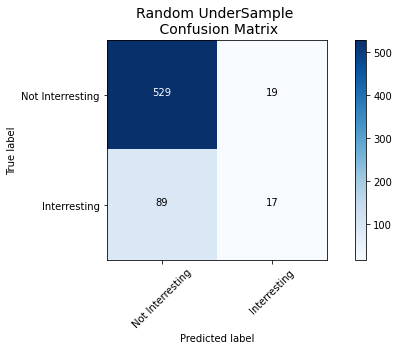

In [155]:
from sklearn.metrics import confusion_matrix

y_pred = lr_pipeline.predict(Xval_wtitle2)
y_pred

labels = ['Not Interresting', 'Interresting']

confusion_mtx = confusion_matrix(yval, y_pred)

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(confusion_mtx, labels, title="Random UnderSample \n Confusion Matrix")

In [156]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(yval, y_pred))

Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91       548
         1.0       0.47      0.16      0.24       106

    accuracy                           0.83       654
   macro avg       0.66      0.56      0.57       654
weighted avg       0.79      0.83      0.80       654



# Abordagen

default primeiraria (datas normais)
+ logisc regression:
  - average_precision_score(yval, p), roc_auc_score(yval,p)
      - 0.35192497202088263 0.733467336683417

````
       precision    recall  f1-score   support

         0.0       0.82      0.99      0.90       900
         1.0       0.53      0.04      0.07       199

    accuracy                           0.82      1099
   macro avg       0.68      0.52      0.49      1099
weighted avg       0.77      0.82      0.75      1099
````


2 Aborgagem: mudar a data para 2021
 - melhorou os resultados
 - a logistic sozinha foi para Logistic Regression
0.3957776583957542 0.7869267318551165
````
Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91       548
         1.0       0.47      0.16      0.24       106

    accuracy                           0.83       654
   macro avg       0.66      0.56      0.57       654
weighted avg       0.79      0.83      0.80       654
````

In [168]:
import joblib as jb

# jb.dump(mdl_lgbm, "lgbm_2021-12-11.pkl.z")
jb.dump(lr_pipeline, "logistic_reg_2021-12-23.pkl.z")
#jb.dump(lr_pipeline, "logistic_reg_20200208.pkl.z")
jb.dump(title_vec, "title_vectorizer_2021-12-23.pkl.z")

['title_vectorizer_2021-12-23.pkl.z']

## Test Keras DeepLarning

https://towardsdatascience.com/pretrained-word-embeddings-using-spacy-and-keras-textvectorization-ef75ecd56360

In [159]:
Xval_wtitle2.shape

(654, 12978)

In [165]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
# from keras.optimizers import Adam
# from tensorflow.keras.optimizers import Adam
from keras.optimizers import adam_v2
from keras.metrics import categorical_crossentropy

# Tamanho da camada de entrada
n_inputs = 12978

# Criação da rede
keras_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [167]:
keras_model.compile(adam_v2.Adam(lr=0.001),
  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Xtrain, Xval = features[mask_train], features[mask_val]
# ytrain, yval = y[mask_train], y[mask_val]
####
# Xtrain_wtitle2 = sparse.csr_matrix(Xtrain_wtitle.copy())
# Xval_wtitle2 = sparse.csr_matrix(Xval_wtitle.copy())

# train: Xtrain_wtitle2 | Xtrain_wtitle | Xtrain | ytrain
# test : Xval_wtitle2 | Xval_wtitle | Xval | yval

keras_model.fit(
    Xtrain_wtitle2, ytrain, validation_split=0.2,
     batch_size=300, epochs=20, shuffle=True, verbose=0)

# Show Result

predictions = keras_model.predict_classes(
    Xval_wtitle2, batch_size=200, verbose=0)

print("Neural Net KERAS with SMOTETomek:\n")
print(classification_report(yval, predictions,
                            target_names=['No', 'Yes']))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


ValueError: ignored